In [51]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [52]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

Reflect Tables into SQLAlchemy ORM

In [53]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [54]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [55]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

In [56]:
# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [57]:
# Using the inspector to print the column names within the 'measurement' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [58]:
# Using the inspector to print the column names within the 'station' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [59]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [60]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [61]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [62]:
# Display the row's columns and data in dictionary format
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1338ebeca58>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [63]:
# Total dates
session.query(func.count(Measurement.date)).all()

[(19550)]

In [66]:
# Earliest Date
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01')

 Exploratory Climate Analysis

In [67]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

# Latest Date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [68]:
# Perform a query to retrieve the data and precipitation scores
results= session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date > '2016-08-22').\
        order_by(Measurement.date).all()

In [69]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

df = pd.DataFrame(results, columns=['date', 'precipitation'])
df = df.sort_values('date')
df.head(10)

,date,precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02
5,2016-08-23,1.79
6,2016-08-23,0.70
13,2016-08-24,1.45
12,2016-08-24,2.15
11,2016-08-24,1.22


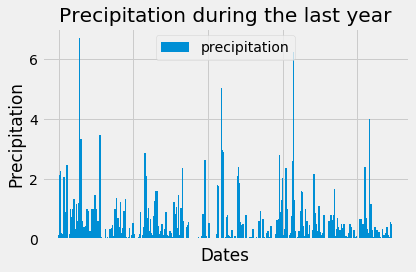

In [70]:
# Use Pandas Plotting with Matplotlib to plot the data

fig, ax = plt.subplots()
xpos = range(1, len(df['date'])+1)
ax.bar(xpos, df['precipitation'],width=10)
ax.set_xlabel("Dates")
ax.set_ylabel("Precipitation")
#ax.set_xticks(xpos)
#ax.set_xticklabels(df['date'])
#plt.xticks(rotation=90)
ax.set_title("Precipitation during the last year")
plt.legend(['precipitation'],loc='upper center')
#ax.grid(linestyle='-', linewidth='0.5', color='gray')
#ax.axes.get_xaxis().set_visible(False)
#plt.xticks([], [])
plt.grid(True)
ax.xaxis.set_ticklabels([])
fig.tight_layout()
plt.show()
fig.savefig('prcp_last_year.png')

In [71]:
# Use Pandas to calcualte the summary statistics for the precipitation data

prec = df.iloc[:, -1]
mean_prec=prec.mean()
mod_prec=prec.mode()
media_prec=prec.median()
var_prec = prec.sem()
print("The mean of precipitacion is {}".format(mean_prec))
print("The mode of precipitacion is {}".format(mod_prec))
print("The media of precipitacion is {}".format(media_prec))
print("The standard error on means of precipitacion is {}".format(var_prec))

The mean of precipitacion is 0.17727857496288896
The mode of precipitacion is 0    0.0
dtype: float64
The media of precipitacion is 0.02
The standard error on means of precipitacion is 0.010258792791451839


Station Analysis

In [72]:
# Design a query to show how many stations are available in this dataset?

session.query(Measurement.station).distinct(Measurement.station).count()

9

In [73]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [79]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').group_by(Measurement.station).all()

[(54.0, 85.0, 71.66378066378067)]

In [80]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

session.query(Measurement.date).filter(Measurement.station == 'USC00519281').order_by(Measurement.date.desc()).first()

('2017-08-18')

In [116]:
results_station= session.query(Measurement.date, Measurement.tobs).\
        filter(Measurement.date > '2016-08-17').\
        filter(Measurement.station == 'USC00519281').order_by(Measurement.date).all()

In [117]:
df = pd.DataFrame(results_station, columns=['date', 'temperature'])
df = df.sort_values('date')
df.head(10)

,date,temperature
0,2016-08-18,80.0
1,2016-08-19,79.0
2,2016-08-20,81.0
3,2016-08-21,79.0
4,2016-08-22,78.0
5,2016-08-23,77.0
6,2016-08-24,77.0
7,2016-08-25,80.0
8,2016-08-26,80.0
9,2016-08-27,75.0


<function matplotlib.pyplot.show(*args, **kw)>

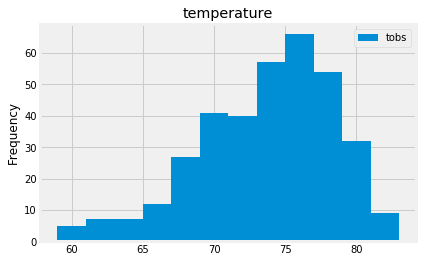

In [120]:
hist = df.hist(column='temperature', bins=12)
#plt.hist(df['temperature'], density=12, bins=12)
plt.ylabel('Frequency')
plt.legend(['tobs'],loc='upper right')
plt.show

In [74]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2015-07-11', '2015-07-31'))

[(71.0, 77.84375, 84.0)]


In [75]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2016-07-11', '2016-08-09'))

[(71.0, 77.83783783783784, 83.0)]


In [84]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
results_vacation= session.query(Measurement.date, func.avg(Measurement.tobs)).\
        filter(Measurement.date > '2016-07-11').\
        filter(Measurement.date < '2016-08-09').group_by(Measurement.date).all()
print(results_vacation)

[('2016-07-12', 78.85714285714286), ('2016-07-13', 76.66666666666667), ('2016-07-14', 78.14285714285714), ('2016-07-15', 76.71428571428571), ('2016-07-16', 77.0), ('2016-07-17', 77.4), ('2016-07-18', 76.57142857142857), ('2016-07-19', 77.71428571428571), ('2016-07-20', 78.42857142857143), ('2016-07-21', 78.4), ('2016-07-22', 77.25), ('2016-07-23', 76.4), ('2016-07-24', 77.2), ('2016-07-25', 79.0), ('2016-07-26', 78.83333333333333), ('2016-07-27', 79.42857142857143), ('2016-07-28', 79.66666666666667), ('2016-07-29', 78.0), ('2016-07-30', 76.8), ('2016-07-31', 76.4), ('2016-08-01', 76.16666666666667), ('2016-08-02', 76.57142857142857), ('2016-08-03', 78.42857142857143), ('2016-08-04', 78.0), ('2016-08-05', 78.5), ('2016-08-06', 78.16666666666667), ('2016-08-07', 78.83333333333333), ('2016-08-08', 79.57142857142857)]


In [107]:
df_vacation = pd.DataFrame(results_vacation, columns=['date', 'temperature'])
df_vacation = df_vacation.sort_values('date')

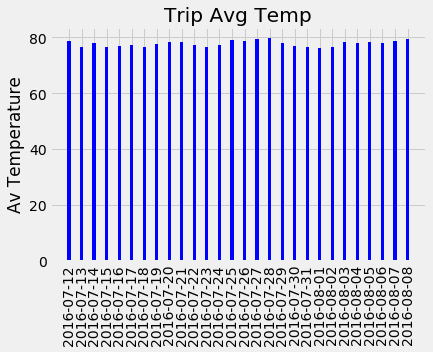

In [112]:
x = df_vacation.iloc[:, -2]
y = df_vacation.iloc[:, -1]
width = 0.25
plt.bar(x, y, width, color="blue")
plt.xticks(rotation=90)
ax.set_xlabel("Dates")
plt.ylabel('Av Temperature')
plt.title('Trip Avg Temp')
plt.show()

In [135]:
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
import numpy as np
from scipy.stats import sem
df_vacation_temp = df_vacation.iloc[:, -1] 
tvacation = list(np.ravel(df_vacation_temp))
print(tvacation)

[78.85714285714286, 76.66666666666667, 78.14285714285714, 76.71428571428571, 77.0, 77.4, 76.57142857142857, 77.71428571428571, 78.42857142857143, 78.4, 77.25, 76.4, 77.2, 79.0, 78.83333333333333, 79.42857142857143, 79.66666666666667, 78.0, 76.8, 76.4, 76.16666666666667, 76.57142857142857, 78.42857142857143, 78.0, 78.5, 78.16666666666667, 78.83333333333333, 79.57142857142857]


In [141]:
means_vac = [np.mean(tvacation)]
standard_errors_vac = [np.std(tvacation)]
print(means_vac)
print(standard_errors_vac)

[77.82542517006802]
[1.0430291485155883]


In [143]:
results_vacation_max= session.query(Measurement.date, func.max(Measurement.tobs)).\
        filter(Measurement.date > '2016-07-11').\
        filter(Measurement.date < '2016-08-09').group_by(Measurement.date).all()
print(results_vacation_max)

[('2016-07-12', 80.0), ('2016-07-13', 79.0), ('2016-07-14', 82.0), ('2016-07-15', 80.0), ('2016-07-16', 80.0), ('2016-07-17', 82.0), ('2016-07-18', 80.0), ('2016-07-19', 80.0), ('2016-07-20', 82.0), ('2016-07-21', 80.0), ('2016-07-22', 78.0), ('2016-07-23', 79.0), ('2016-07-24', 79.0), ('2016-07-25', 81.0), ('2016-07-26', 82.0), ('2016-07-27', 83.0), ('2016-07-28', 82.0), ('2016-07-29', 82.0), ('2016-07-30', 78.0), ('2016-07-31', 80.0), ('2016-08-01', 78.0), ('2016-08-02', 80.0), ('2016-08-03', 82.0), ('2016-08-04', 81.0), ('2016-08-05', 81.0), ('2016-08-06', 80.0), ('2016-08-07', 83.0), ('2016-08-08', 83.0)]


In [146]:
df_vacation_max = pd.DataFrame(results_vacation_max, columns=['date', 'temperature'])

In [144]:
results_vacation_min= session.query(Measurement.date, func.min(Measurement.tobs)).\
        filter(Measurement.date > '2016-07-11').\
        filter(Measurement.date < '2016-08-09').group_by(Measurement.date).all()
print(results_vacation_min)

[('2016-07-12', 75.0), ('2016-07-13', 74.0), ('2016-07-14', 73.0), ('2016-07-15', 71.0), ('2016-07-16', 73.0), ('2016-07-17', 74.0), ('2016-07-18', 72.0), ('2016-07-19', 73.0), ('2016-07-20', 74.0), ('2016-07-21', 77.0), ('2016-07-22', 76.0), ('2016-07-23', 74.0), ('2016-07-24', 75.0), ('2016-07-25', 77.0), ('2016-07-26', 76.0), ('2016-07-27', 76.0), ('2016-07-28', 76.0), ('2016-07-29', 74.0), ('2016-07-30', 76.0), ('2016-07-31', 75.0), ('2016-08-01', 73.0), ('2016-08-02', 72.0), ('2016-08-03', 74.0), ('2016-08-04', 74.0), ('2016-08-05', 75.0), ('2016-08-06', 76.0), ('2016-08-07', 77.0), ('2016-08-08', 75.0)]


In [147]:
df_vacation_min = pd.DataFrame(results_vacation_min, columns=['date', 'temperature'])

In [131]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.prcp]
same_station = session.query(*sel).filter(Measurement.station == Station.station).\
filter(Measurement.date >= '2016-07-11').filter(Measurement.date <= '2016-08-09').\
order_by(Measurement.prcp.desc()).all()
same_station

[('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  9.64),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 7.65),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  5.35),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 4.2),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  3.53),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  3.01),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  2.9),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  2.75),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 2.35),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  2.21),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  2.05),
 ('USC00516128',
  'MANOA LY

In [98]:
# Plot sample means with error bars
fig, ax = plt.subplots()

ax.errorbar(np.arange(0, len(means_vac)), ax.errorbar(np.arange(0, len(means_vac)), means, yerr=standard_errors_vac, fmt="o", color="b",
            alpha=0.5, label="Mean of House Prices")

ax.set_xlim(-0.5, len(means_vac))

ax.set_xlabel("Sample Number")
ax.set_ylabel("Mean of Median House Prices")

plt.legend(loc="best", fontsize="small", fancybox=True)

plt.show()

SyntaxError: invalid syntax (<ipython-input-98-ada61ee47aae>, line 7)